In [2]:
from tqdm import tqdm, trange, tqdm_notebook

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from numpy import pi, e

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.externals.joblib import dump as model_dump, load as model_load

from sklearn.ensemble import GradientBoostingClassifier


import scipy.io.wavfile
import scipy.fftpack

import librosa
import youtube_dl

import os
import sys
import subprocess as sub

import re

# Strange precalculated dataset

In [180]:
data = pd.read_csv('./voice.csv')

In [181]:
X = data[['meanfreq', 'median', 'Q25', 'Q75']]#data.axes[1][:-1]]
Y = data[data.axes[1][-1]]
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.5)

In [182]:
model = RandomForestClassifier(n_estimators=70, max_depth=16)

In [183]:
model.fit(X_tr, Y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [184]:
Y_tr_pred = model.predict(X_tr)
Y_ts_pred = model.predict(X_ts)

print('Train:', accuracy_score(Y_tr, Y_tr_pred))
print('Test:', accuracy_score(Y_ts, Y_ts_pred))

Train: 0.9993686868686869
Test: 0.928030303030303


# Installing librosa and youtube_dl
<b>librosa</b> helps to open audio files (also <a href="http://ffmpeg.org/download.html"><b>ffmpeg</b></a> binary must be installed)<br/>
<b>youtube_dl</b> helps to download videos from <a href="https://youtube.com">youtube.com</a>
<pre>pip install librosa
pip install --upgrade youtube_dl</pre>

In [3]:
def youtube_download(urls, ydl_opts={}):
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download(urls)

def extract_sound_from_file(filename, rm_after=False):
    sound = librosa.load(filename)
    scipy.io.wavfile.write(filename + '.wav', sound[1], sound[0])
    if rm_after:
        os.system('rm "{}"'.format(filename))

In [ ]:
youtube_download([''])

## Extracting sound features for decision trees

In [2]:
def half(sth):
    return sth[:len(sth)//2]

def quantiles_freq(ratios, data):
    '''Frequency quantiles O(n)'''
    assert len(data) > 0
    
    full_sum = np.sum(data)
    vals = np.array(ratios) * full_sum
    ans = np.zeros(len(ratios))
    cur_sum = 0
    i, j = 0, 0
    while i < len(data) and j < len(vals):
        if cur_sum >= vals[j]:
            ans[j] = i
            j += 1
        cur_sum += data[i]
        i += 1
    while j < len(vals):
        ans[j] = len(data)
        j += 1
    
    return ans

def smooth(np_array):
    ans = np.zeros(len(np_array) + 16)
    for i in range(16):
        ans[i : i + len(np_array)] += np_array
    return ans[8:-8] / 16

In [3]:
def sound_features(sound_data, sample_rate, smooth_ = True, cut_infra_ultra = None):
    '''Works only if count of samples more than 3'''
    import scipy.fftpack
    
    N_add = 144
    if len(sound_data) % N_add != 0:
        diff = sound_data[-1] - sound_data[-2]
        add = np.arange(1, 1 + len(sound_data) % N_add) * diff + sound_data[-1]
        sound_data = np.concatenate((sound_data, add))

    freq_amp = half(np.abs(scipy.fftpack.fft(sound_data)))
    freq_amp = (freq_amp > freq_amp.max()*1e-3) * freq_amp # Kostyli because of noise
    if cut_infra_ultra is not None:
        freq_amp[: int(2 * cut_infra_ultra[0] / sample_rate * len(freq_amp))  ] *= 0
        freq_amp[  int(2 * cut_infra_ultra[1] / sample_rate * len(freq_amp)) :] *= 0
    if smooth_:
        freq_amp = smooth(freq_amp)
    freq_amp /= np.sum(freq_amp)

    mean_freq = np.sum(freq_amp * (np.arange(len(freq_amp)) / len(freq_amp) * sample_rate/2))
    peak = freq_amp.argmax() / len(freq_amp) * sample_rate/2

    q25, q333, median, q666, q75 = quantiles_freq((0.25, 1/3, 0.5, 2/3, 0.75), freq_amp) / len(freq_amp) * sample_rate/2
    
    dispersion = np.sum(freq_amp * (np.arange(len(freq_amp)) / len(freq_amp) * sample_rate/2 - mean_freq) ** 2) / len(freq_amp)
    st_dev = np.sqrt(dispersion)
    
    mu3 = np.sum(freq_amp * (np.arange(len(freq_amp)) / len(freq_amp) * sample_rate/2 - mean_freq) ** 3) / len(freq_amp)
    mu4 = np.sum(freq_amp * (np.arange(len(freq_amp)) / len(freq_amp) * sample_rate/2 - mean_freq) ** 4) / len(freq_amp)
    
    skewness = mu3 / (st_dev ** 3)
    kurtosis = mu4 / (st_dev ** 4) - 3

    return mean_freq, peak, q25, q333, median, q666, q75, dispersion, st_dev, skewness, kurtosis


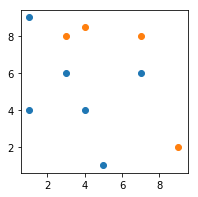

In [102]:
cnt_smooth = 8
slc = 20000

for fname in ():#((r"LibriSpeech\test-clean\test-clean\5639\40744\5639-40744-0005.flac", 'b'),
             # (r"LibriSpeech\test-clean\test-clean\1995\1836\1995-1836-0008.flac", 'r')):
    sound = librosa.load(fname[0])
    fft_ = np.abs(scipy.fftpack.fft(sound[0]))
    #for i in range(cnt_smooth):
    #    fft_ = (np.concatenate(([0], fft_)) + np.concatenate((fft_, [0])))/2
    print(sound_features(sound[0], sound[1]))
    fft_ = smooth(fft_)

    fft_ /= fft_.max()
    plt.figure(figsize=(16, 9))
    plt.xticks(np.arange(0, 1 + slc/len(fft_)*sound[1], 200.0))
    plt.plot(np.linspace(0, 1, slc) * 22050 * slc / len(fft_), fft_[:slc], fname[1])
    plt.show()

plt.figure(figsize=(3, 3))
plt.scatter(*list(zip(*[(1, 4), (1, 9), (3, 6), (4, 4), (5, 1), (7, 6)])))
plt.scatter(*list(zip(*[(3, 8), (4, 8.5), (7, 8), (9, 2)])))

# LibriSpeech
Here we'll try to train model with <a href="http://www.openslr.org/12"><b>LibriSpeech</b></a> dataset

In [4]:
def sound_features_from_LibriSpeech_files(dirname, tqdm_ = False, smooth_ = True, cut_infra_ultra=None):
    '''For more information see code'''
    
    speakers_filename = dirname + '/../SPEAKERS.txt'
    pat = '(?P<id>[0-9]+)[ ]*\\|[ ]*(?P<gender>[FM])[ ]*\\|[ ]*[a-zA-Z\\-0-9]+[ ]*\\|[ ]*[0-9\\.]+[ ]*\\|[a-zA-Z ]+'
    with open(speakers_filename) as speakers_file:
        speakers_text = speakers_file.read()
    gender = {int(m.groupdict()['id']): m.groupdict()['gender'] for m in re.finditer(pat, speakers_text)}
    
    data = []
    for dir_ in tqdm_notebook(list(os.walk(dirname)), desc="dir"):
        try:
            for file in tqdm_notebook(dir_[-1], desc="file", leave=False):
                if file.endswith('.flac'):
                    speaker = dir_[0][len(dirname)+1:]
                    speaker = int(speaker[:speaker.find('\\')])
                    
                    sound = librosa.load(dir_[0] + '\\' + file)
                    data.append(sound_features(*sound, smooth_=smooth_, cut_infra_ultra=cut_infra_ultra)
                                + (gender[speaker], speaker, dir_[0] + '\\' + file))
        except KeyboardInterrupt:
            pass
    
    axes = ('meanfreq', 'peak', 'q25', 'q333', 'median', 'q666', 'q75', 'dispersion', 'std. dev', 'skewness', 'kurtosis',
            'gender', 'speaker', 'filename')
    data_np_T = np.array(data).T
    return pd.DataFrame({axis: data_np_T[i] for i, axis in enumerate(axes)})

In [8]:
spk = sound_features_from_LibriSpeech_files(r'./LibriSpeech/test-other/test-other', True, True, (40, 7000))
spk.to_csv('./sound-features-test-LibriSpeech-other-smoothed-range40-7000.csv')

HBox(children=(IntProgress(value=0, description='dir', max=124), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=97), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=29), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=41), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=24), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=19), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=12), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=37), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=3), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=40), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=26), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=32), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=35), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=27), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=132), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=22), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=59), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=56), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=22), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=32), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=31), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=62), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=29), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=27), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=27), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=29), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=29), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=33), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=39), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=99), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=31), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=21), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=29), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=27), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=61), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=59), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=32), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=33), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=39), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=52), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=27), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=19), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=20), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=63), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=24), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=59), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=59), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=13), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=67), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='file', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, description='file', max=40), HTML(value='')))

In [5]:
def to_DataFrame_sf(data_np):
    ans =  pd.DataFrame({'meanfreq':   np.array(data_np.T[0], dtype='float32'),
                         'peak':       np.array(data_np.T[1], dtype='float32'),
                         'q25':        np.array(data_np.T[2], dtype='float32'),
                         'q333':       np.array(data_np.T[3], dtype='float32'),
                         'meidan':     np.array(data_np.T[4], dtype='float32'),
                         'q666':       np.array(data_np.T[5], dtype='float32'),
                         'q75':        np.array(data_np.T[6], dtype='float32'),
                         'dispersion': np.array(data_np.T[7], dtype='float32'),
                         'std. dev.':  np.array(data_np.T[8], dtype='float32'),
                         'skewness':   np.array(data_np.T[9], dtype='float32'),
                         'kurtosis':   np.array(data_np.T[10], dtype='float32')})
    if len(data_np.T) >= 12:
        ans['male'] = data_np.T[11]
    return ans

In [6]:
data_clean = to_DataFrame_sf(np.load("test-clean-data-smoothed.npy"))
data_other = to_DataFrame_sf(np.load("test-other-data-smoothed.npy"))
data = to_DataFrame_sf(np.concatenate((np.load("test-clean-data-smoothed.npy"), np.load("test-other-data-smoothed.npy"))))

In [7]:
X_clean = data_clean[list(filter(lambda s: s != 'male', list(data.axes[1])))]
Y_clean = data_clean['male']

X_other = data_other[list(filter(lambda s: s != 'male', list(data.axes[1])))]
Y_other = data_other['male']

X = data[list(filter(lambda s: s != 'male', list(data.axes[1])))]
Y = data['male']

In [8]:
X_other_tr, X_other_ts, Y_other_tr, Y_other_ts = train_test_split(X_other, Y_other, test_size=0.1)
X_clean_tr, X_clean_ts, Y_clean_tr, Y_clean_ts = train_test_split(X_clean, Y_clean, test_size=0.1)

X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.1)

Searching the best ...

HBox(children=(IntProgress(value=0), HTML(value='')))

(array([ 3.,  4., 11.,  9., 22., 24.,  5., 11.,  8.,  3.]),
 array([0.82014388, 0.82320144, 0.82625899, 0.82931655, 0.8323741 ,
        0.83543165, 0.83848921, 0.84154676, 0.84460432, 0.84766187,
        0.85071942]),
 <a list of 10 Patch objects>)

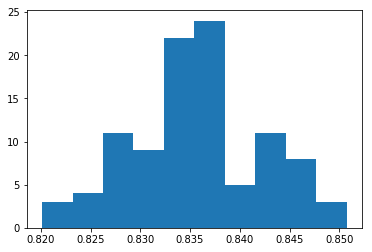

In [41]:
accs = []
for i in tqdm_notebook(range(100)):
    model = RandomForestClassifier(n_estimators=91, max_depth=10)
    model.fit(X_tr, Y_tr)
    
    Y_ts_pred = model.predict(X_ts)
    accs.append((accuracy_score(Y_ts, Y_ts_pred), model))

accs.sort(key = lambda p: p[0])
the_best = accs[-1][1]
plt.hist(zip(*accs).__next__())

In [107]:
print('Tr:', accuracy_score(Y_tr, the_best.predict(X_tr)))
print('Ts:', accuracy_score(Y_ts, the_best.predict(X_ts)))
print('Other:', accuracy_score(Y_other, the_best.predict(X_other)))
print('Clean:', accuracy_score(Y_clean, the_best.predict(X_clean)))

Tr: 0.963222066759944
Ts: 0.9730215827338129
Other: 0.9734603606668935
Clean: 0.9538167938931298


In [108]:
fname = r'some-sound/youtube-test-audio.wav'

print(the_best.predict_proba( to_DataFrame_sf(np.array([ np.array(sound_features(*librosa.load(fname), True)) ])) ))

[[0.87071297 0.12928703]]


# Testing <a href="https://voice.mozilla.org/en/data">Common Voice</a> dataset

In [ ]:
pd.read_csv('some-sound/cv_corpus_v1.tar.gz/cv_corpus_v1/cv-valid-dev.csv')

# Testing gradient boosting

In [ ]:
avgs = [[], []]
for i in trange(1):
    X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.01)
    
    model = GradientBoostinClassifier(n_estimators=70, max_depth=3)
    model.fit(X_tr, Y_tr)
    Y_ts_pred = model.predict(X_ts)
    avgs[0].append(accuracy_score(Y_ts, Y_ts_pred))
    
    #X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.01)
    ##model = DecisionTreeClassifier(max_depth=16)
    model = RandomForestClassifier(n_estimators=70, max_depth=16)
    model.fit(X_tr, Y_tr)
    Y_ts_pred = model.predict(X_ts)
    avgs[1].append(accuracy_score(Y_ts, Y_ts_pred))

In [317]:
print(np.array(avgs[0]).mean(), '+-',
      np.sqrt(np.array(avgs[0]).var()))

print(np.array(avgs[1]).mean(), '+-',
      np.sqrt(np.array(avgs[1]).var()))

0.8881481481481479 +- 0.0578489590019835
0.8899999999999999 +- 0.060053702533055094


In [318]:
scipy.stats.ttest_rel(*avgs)

Ttest_relResult(statistic=-0.5165717386636469, pvalue=0.6066071666924862)

In [308]:
import random

p = 0.9 + 0

ans = []
for i in range(10000):
    data = [int(random.random() < p) for i in range(100)]
    ans.append(np.sum(data))

In [309]:
np.percentile(ans, 95)

95.0

In [310]:
bla = np.array(ans)
np.mean(bla >= 58)

1.0

(array([   5.,   47.,  161.,  513., 1263., 3488., 2444., 1547.,  457.,
          75.]),
 array([77. , 79.2, 81.4, 83.6, 85.8, 88. , 90.2, 92.4, 94.6, 96.8, 99. ]),
 <a list of 10 Patch objects>)

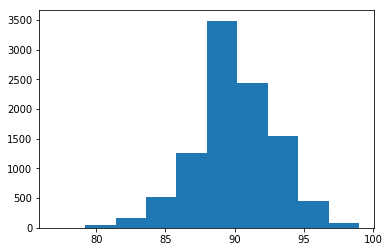

In [312]:
plt.hist(ans)